This notebook includes a first sketch of the ShorelineNet implementation in pytorch. 

In particular I want to achieve the following: 
* config loading
* network saving & loading
* try to wrap everything in classes
* where possible, use type annotations
* experiment with MC dropout & posterior estimation

15 Jan: loaded images
Next session: get transformations to work
Create network architecture & load pre-trained encoder

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
import os

from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torch import ones_like, zeros_like

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# load MaSTr dataset
mastr_path = '../../project_offline/Dataset/MaSTr1325/'

data_transforms = {
    'img': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(0, 1),
        # transforms.ToTensor(),
    ]), 
    'mask': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(0, 1),
        # transforms.ToTensor(),
    ])
}


In [59]:
class MastrDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.transform = transform

        # TODO: find out if this needs shuffle?
        self.img_file_names = os.listdir(img_dir)

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_file_names[idx])
        label_path = os.path.join(
            self.label_dir, self.img_file_names[idx].replace(".jpg", "m.png"))

        image = read_image(img_path)
        # TODO: find out if this is inefficient over many epochs
        label = read_image(label_path)

        # NOTE: image format: (C, W, H)

        label = torch.where(label==4, ones_like(label)*3, label)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label



In [60]:
class ImageDisplayer():
    def __init__(self, images, labels, predictions=None):
        self.images = images
        self.labels = labels
        self.predictions = predictions

    def show_sample(self, idx=None):
        if idx is None:
            idx = np.random.randint(0, len(self.images))
        img = self.images[idx].permute(1, 2, 0)
        labels = self.labels[idx].permute(1, 2, 0)

        plt.subplot(1, 2, 1)
        plt.title('Input Image')
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('True Mask')
        plt.imshow(labels)
        plt.axis('off')

        plt.tight_layout()



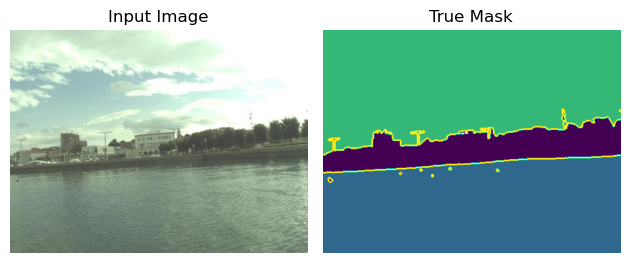

In [61]:
dataset = MastrDataset(os.path.join(mastr_path, 'images'),
                       os.path.join(mastr_path, 'masks'), None)

train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

imgs, labels = next(iter(train_dataloader))
img_displayer = ImageDisplayer(imgs, labels)
img_displayer.show_sample(idx=0)
